In [32]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os

## **Data Directory**

In [33]:
data_dir = '/content/drive/MyDrive/SkinData'

## **Data augmentation and Image Generators**

In [40]:
dg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = dg.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = dg.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3834 images belonging to 4 classes.
Found 958 images belonging to 4 classes.


## **VGG16 model**

In [41]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## **Modal Training**

In [2]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=5
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 3121s 26s/step - accuracy: 0.4924 - loss: 1.1501 - val_accuracy: 0.6767 - val_loss: 0.7546
Epoch 2/5
  1/119 ━━━━━━━━━━━━━━━━━━━━ 38:53 20s/step - accuracy: 0.7500 - loss: 0.6006

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


119/119 ━━━━━━━━━━━━━━━━━━━━ 69s 414ms/step - accuracy: 0.7500 - loss: 0.6006 - val_accuracy: 0.7000 - val_loss: 0.8020
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 3118s 26s/step - accuracy: 0.7323 - loss: 0.7116 - val_accuracy: 0.7047 - val_loss: 0.7495
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - accuracy: 0.7812 - loss: 0.5545 - val_accuracy: 0.6000 - val_loss: 0.8533
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 3069s 26s/step - accuracy: 0.7716 - loss: 0.5996 - val_accuracy: 0.7295 - val_loss: 0.6670


In [5]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=2
)

Epoch 1/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 3625s 30s/step - accuracy: 0.8101 - loss: 0.5092 - val_accuracy: 0.7543 - val_loss: 0.5794
Epoch 2/2
119/119 ━━━━━━━━━━━━━━━━━━━━ 44s 157ms/step - accuracy: 0.8750 - loss: 0.3658 - val_accuracy: 0.7333 - val_loss: 0.7461


## **Evaluate**

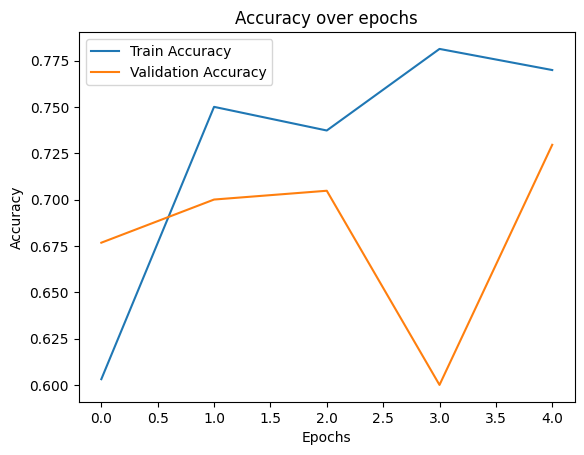

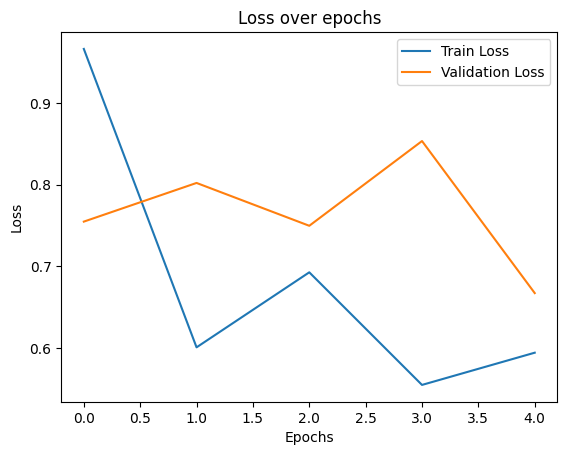

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## **Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


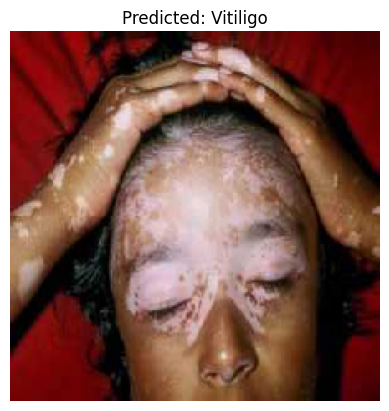

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

skin_class = ['Acne', 'Eczema', 'Healthy', 'Vitiligo']

img_path = '/content/drive/MyDrive/SkinData/vitiligo/18.png'
img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
predicted_label = skin_class[predicted_class]

plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


## **Save Modal**

In [31]:
model.save('/content/drive/MyDrive/SkinData/vgg16_skin_disease_detection.keras')

model.save_weights('/content/drive/MyDrive/SkinData/vgg16_weights.weights.h5')